In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
plt.style.use("ggplot")

matplotlib.rcParams["axes.titlesize"] = 11
matplotlib.rcParams["axes.titlecolor"] = "#333333"
matplotlib.rcParams["legend.facecolor"] = "#fbfbfb"

In [3]:
def get_title(forward_only, parallel):
    """Generate title for plot"""
    title = "Forward only" if forward_only else "Sensitivity matrix"
    if parallel:
        title += " (parallel)"
    else:
        title += " (single thread)"
    return title

In [4]:
results_dir = Path("..") / "results"
for f in results_dir.iterdir():
    print(f)

../results/benchmarks-serial.nc
../results/benchmarks-threads.nc
../results/benchmarks-serial-vector.nc
../results/benchmarks-parallel-vector.nc
../results/benchmarks-dask.nc
../results/benchmarks-parallel.nc


## Serial

In [5]:
fname = results_dir / "benchmarks-serial.nc"
single_thread = xr.load_dataset(fname)
single_thread

<xarray.Dataset> Size: 826B
Dimensions:       (n_cells: 6, forward_only: 2, field: 2, engine: 2)
Coordinates:
  * n_cells       (n_cells) int32 24B 1000 8000 27000 64000 125000 216000
  * engine        (engine) object 16B 'choclo' 'geoana'
  * field         (field) object 16B 'tmi' 'b'
  * forward_only  (forward_only) bool 2B True False
Data variables:
    times         (forward_only, n_cells, field, engine) float64 384B 0.1128 ...
    times_std     (forward_only, n_cells, field, engine) float64 384B 0.00011...
Attributes:
    n_receivers:  900

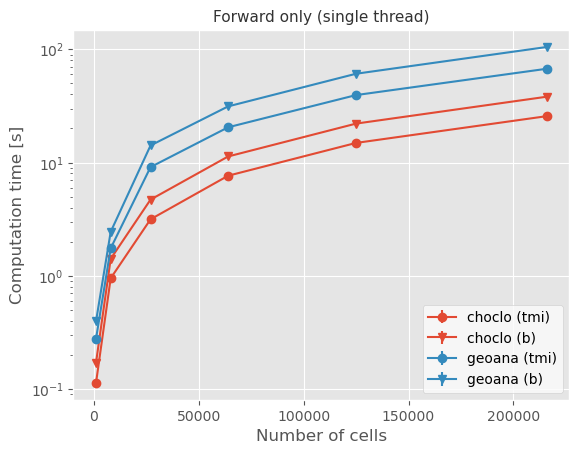

In [6]:
forward_only = True
title = get_title(forward_only, parallel=False)

colors = ["C0", "C1", "C2", "C3"]
markers = ["o", "v"]

for color, engine in zip(colors, single_thread.engine.values):
    for marker, field in zip(markers, single_thread.field.values):
        tmp = single_thread.sel(engine=engine, field=field, forward_only=forward_only)
        plt.errorbar(tmp.n_cells, tmp.times, yerr=tmp.times_std, label=f"{engine} ({field})", marker=marker, color=color)
    
plt.yscale("log")
plt.xlabel("Number of cells")
plt.ylabel("Computation time [s]")
plt.title(title)
plt.legend()
plt.show()

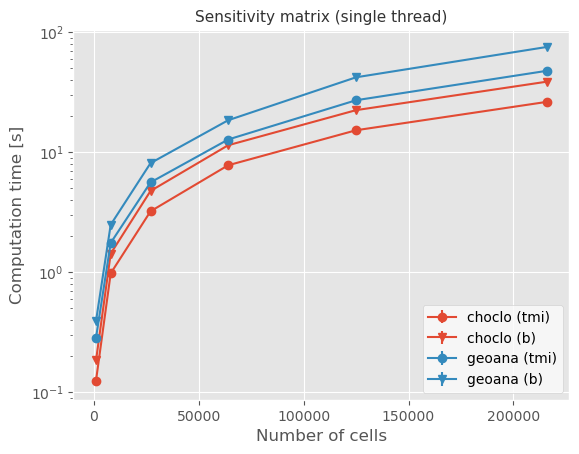

In [7]:
forward_only = False
title = get_title(forward_only, parallel=False)

colors = ["C0", "C1", "C2", "C3"]
markers = ["o", "v"]

for color, engine in zip(colors, single_thread.engine.values):
    for marker, field in zip(markers, single_thread.field.values):
        tmp = single_thread.sel(engine=engine, field=field, forward_only=forward_only)
        plt.errorbar(tmp.n_cells, tmp.times, yerr=tmp.times_std, label=f"{engine} ({field})", marker=marker, color=color)
    
plt.yscale("log")
plt.xlabel("Number of cells")
plt.ylabel("Computation time [s]")
plt.title(title)
plt.legend()
plt.show()

In [8]:
ratii = single_thread.times.sel(engine="geoana") / single_thread.times.sel(engine="choclo")
ratii.name = "Ratio (geoana/choclo)"
ratii

<xarray.DataArray 'Ratio (geoana/choclo)' (forward_only: 2, n_cells: 6, field: 2)> Size: 192B
array([[[2.45308179, 2.32234071],
        [1.83986387, 1.73399453],
        [2.89419461, 3.00960613],
        [2.67998801, 2.7708391 ],
        [2.64808533, 2.75866201],
        [2.62343907, 2.75103925]],

       [[2.27609971, 2.13164957],
        [1.79319874, 1.74270125],
        [1.74235555, 1.70635136],
        [1.63949435, 1.61606247],
        [1.77956911, 1.87910134],
        [1.81515998, 1.94773145]]])
Coordinates:
  * n_cells       (n_cells) int32 24B 1000 8000 27000 64000 125000 216000
  * field         (field) object 16B 'tmi' 'b'
  * forward_only  (forward_only) bool 2B True False

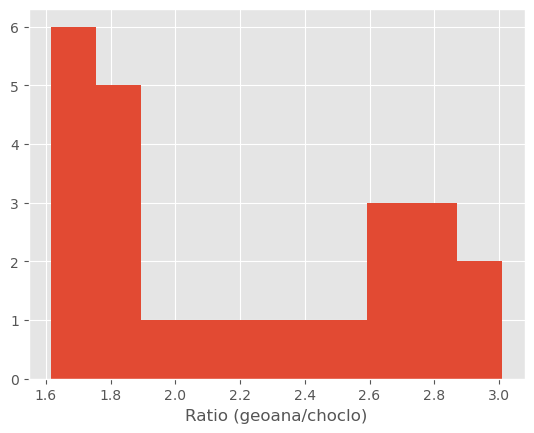

In [9]:
ratii.plot()
plt.show()

In [10]:
ratii.values.min(), ratii.values.max()

(1.6160624700102753, 3.0096061265268856)

## Parallel

In [11]:
fname = results_dir / "benchmarks-parallel.nc"
parallel = xr.load_dataset(fname)
parallel

<xarray.Dataset> Size: 694B
Dimensions:       (n_cells: 5, engine: 2, forward_only: 2, field: 2)
Coordinates:
  * n_cells       (n_cells) int32 20B 8000 64000 216000 512000 1000000
  * engine        (engine) object 16B 'choclo' 'geoana'
  * field         (field) object 16B 'tmi' 'b'
  * forward_only  (forward_only) bool 2B True False
Data variables:
    times         (forward_only, n_cells, field, engine) float64 320B 0.1826 ...
    times_std     (forward_only, n_cells, field, engine) float64 320B 0.0204 ...
Attributes:
    n_receivers:  3600

In [12]:
fname = results_dir / "benchmarks-dask.nc"
dask = xr.load_dataset(fname)
dask

<xarray.Dataset> Size: 358B
Dimensions:       (n_cells: 5, forward_only: 2, field: 2)
Coordinates:
  * n_cells       (n_cells) int32 20B 8000 64000 216000 512000 1000000
  * field         (field) object 16B 'tmi' 'b'
  * forward_only  (forward_only) bool 2B True False
Data variables:
    times         (forward_only, n_cells, field) float64 160B 11.18 ... 242.1
    times_std     (forward_only, n_cells, field) float64 160B 0.08767 ... 3.855
Attributes:
    n_receivers:  3600

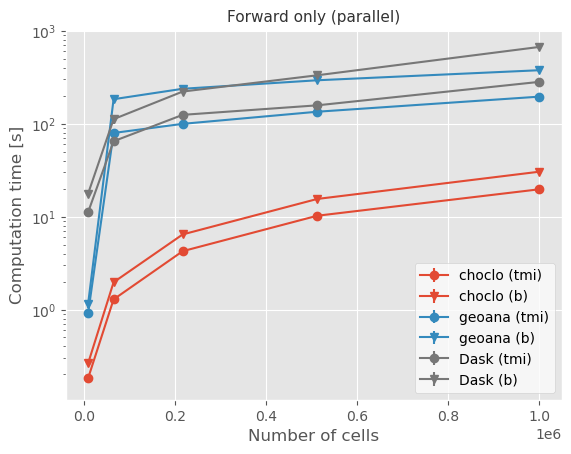

In [13]:
forward_only = True
title = get_title(forward_only, parallel=True)

colors = ["C0", "C1", "C2", "C3"]
markers = ["o", "v"]

for color, engine in zip(colors, parallel.engine.values):
    for marker, field in zip(markers, parallel.field.values):
        tmp = parallel.sel(engine=engine, field=field, forward_only=forward_only)
        plt.errorbar(tmp.n_cells, tmp.times, yerr=tmp.times_std, label=f"{engine} ({field})", marker=marker, color=color)

for marker, field in zip(markers, dask.field.values):
    tmp = dask.sel(field=field, forward_only=forward_only)
    plt.errorbar(tmp.n_cells, tmp.times, yerr=tmp.times_std, label=f"Dask ({field})", marker=marker, color=colors[3])
    
plt.yscale("log")
plt.xlabel("Number of cells")
plt.ylabel("Computation time [s]")
plt.title(title)
plt.legend()
plt.show()

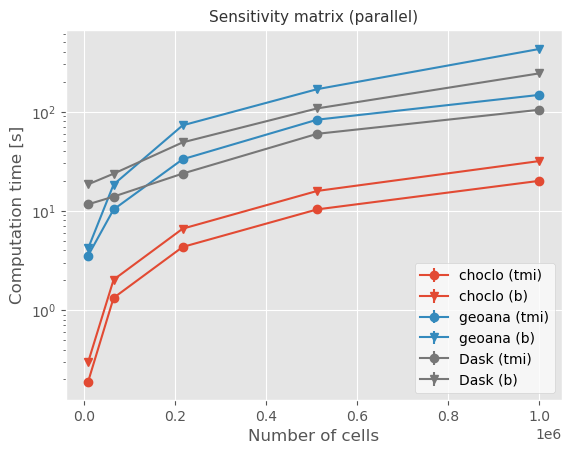

In [14]:
forward_only = False
title = get_title(forward_only, parallel=True)

colors = ["C0", "C1", "C2", "C3"]
markers = ["o", "v"]

for color, engine in zip(colors, parallel.engine.values):
    for marker, field in zip(markers, parallel.field.values):
        tmp = parallel.sel(engine=engine, field=field, forward_only=forward_only)
        plt.errorbar(tmp.n_cells, tmp.times, yerr=tmp.times_std, label=f"{engine} ({field})", marker=marker, color=color)

for marker, field in zip(markers, dask.field.values):
    tmp = dask.sel(field=field, forward_only=forward_only)
    plt.errorbar(tmp.n_cells, tmp.times, yerr=tmp.times_std, label=f"Dask ({field})", marker=marker, color=colors[3])

plt.yscale("log")
plt.xlabel("Number of cells")
plt.ylabel("Computation time [s]")
plt.title(title)
plt.legend()
plt.show()

In [15]:
ratii = parallel.times.sel(engine="geoana") / parallel.times.sel(engine="choclo")
ratii.name = "Ratio (geoana/choclo)"
ratii

<xarray.DataArray 'Ratio (geoana/choclo)' (forward_only: 2, n_cells: 5, field: 2)> Size: 160B
array([[[ 5.00429433,  4.3803044 ],
        [61.73644292, 93.24756909],
        [23.44815927, 36.91080759],
        [13.15669161, 18.92939318],
        [ 9.93017264, 12.36274868]],

       [[18.61041837, 13.99357518],
        [ 7.7687671 ,  9.09292025],
        [ 7.64504573, 10.98457458],
        [ 8.00978974, 10.59359314],
        [ 7.33949792, 13.45078122]]])
Coordinates:
  * n_cells       (n_cells) int32 20B 8000 64000 216000 512000 1000000
  * field         (field) object 16B 'tmi' 'b'
  * forward_only  (forward_only) bool 2B True False

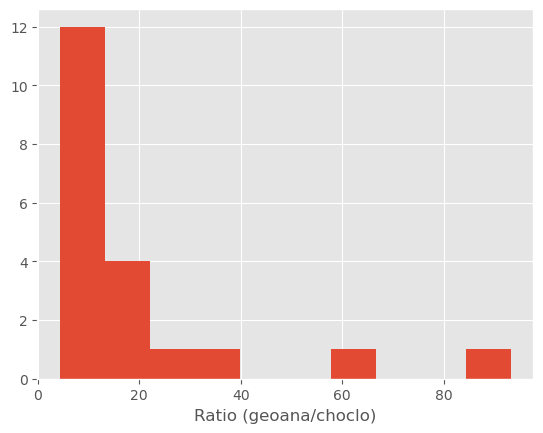

In [16]:
ratii.plot()
plt.show()

In [17]:
ratii.values.min(), ratii.values.max()

(4.380304395114298, 93.24756908808801)

## Threads

In [18]:
fname = results_dir / "benchmarks-threads.nc"
threads = xr.load_dataset(fname)
threads

<xarray.Dataset> Size: 826B
Dimensions:       (threads: 6, forward_only: 2, field: 2, engine: 2)
Coordinates:
  * threads       (threads) int32 24B 1 5 10 20 30 48
  * engine        (engine) object 16B 'choclo' 'geoana'
  * field         (field) object 16B 'tmi' 'b'
  * forward_only  (forward_only) bool 2B True False
Data variables:
    times         (forward_only, threads, field, engine) float64 384B 45.87 ....
    times_std     (forward_only, threads, field, engine) float64 384B 0.00746...
Attributes:
    n_receivers:  1600

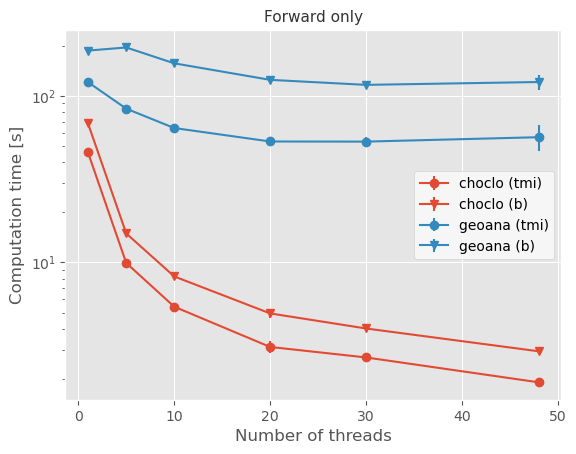

In [19]:
forward_only = True

colors = ["C0", "C1", "C2", "C3"]
markers = ["o", "v"]

for color, engine in zip(colors, threads.engine.values):
    for marker, field in zip(markers, threads.field.values):
        tmp = threads.sel(engine=engine, field=field, forward_only=forward_only)
        plt.errorbar(tmp.threads, tmp.times, yerr=tmp.times_std, label=f"{engine} ({field})", marker=marker, color=color)
    
plt.yscale("log")
plt.xlabel("Number of threads")
plt.ylabel("Computation time [s]")
plt.title("Forward only")
plt.legend()
plt.show()

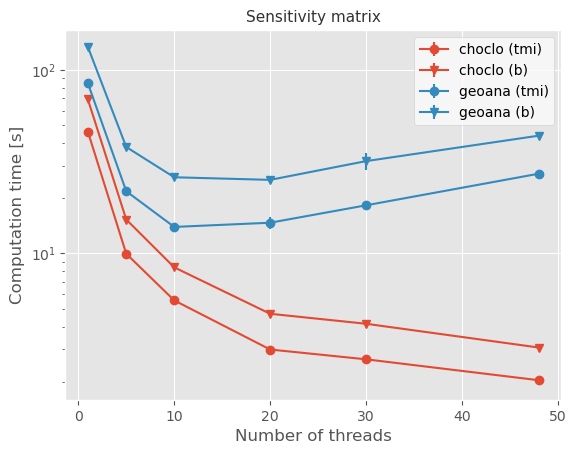

In [20]:
forward_only = False

colors = ["C0", "C1", "C2", "C3"]
markers = ["o", "v"]

for color, engine in zip(colors, threads.engine.values):
    for marker, field in zip(markers, threads.field.values):
        tmp = threads.sel(engine=engine, field=field, forward_only=forward_only)
        plt.errorbar(tmp.threads, tmp.times, yerr=tmp.times_std, label=f"{engine} ({field})", marker=marker, color=color)
    
plt.yscale("log")
plt.xlabel("Number of threads")
plt.ylabel("Computation time [s]")
plt.title("Sensitivity matrix")
plt.legend()
plt.show()

In [21]:
ratii = threads.times.sel(engine="geoana") / threads.times.sel(engine="choclo")
ratii.name = "Ratio (geoana/choclo)"
ratii

<xarray.DataArray 'Ratio (geoana/choclo)' (forward_only: 2, threads: 6, field: 2)> Size: 192B
array([[[ 2.63147145,  2.7224207 ],
        [ 8.43037296, 13.06022148],
        [11.80035729, 18.99097412],
        [17.09117303, 25.19217988],
        [19.72134518, 28.94528279],
        [29.56074478, 41.26889458]],

       [[ 1.83414614,  1.93123599],
        [ 2.18968237,  2.48391026],
        [ 2.51287805,  3.09471584],
        [ 4.90456058,  5.36256846],
        [ 6.90096904,  7.6905174 ],
        [13.33155206, 14.25873719]]])
Coordinates:
  * threads       (threads) int32 24B 1 5 10 20 30 48
  * field         (field) object 16B 'tmi' 'b'
  * forward_only  (forward_only) bool 2B True False

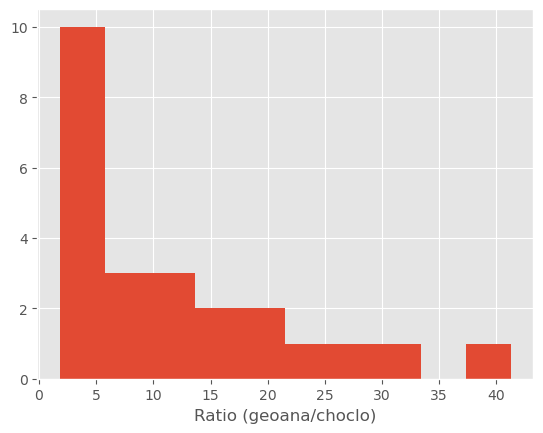

In [22]:
ratii.plot()
plt.show()

In [23]:
ratii.values.min(), ratii.values.max()

(1.8341461409049873, 41.26889458043028)

## Vector model (single thread)

In [24]:
fname = results_dir / "benchmarks-serial-vector.nc"
vector_serial = xr.load_dataset(fname)
vector_serial

<xarray.Dataset> Size: 826B
Dimensions:       (n_cells: 6, forward_only: 2, field: 2, engine: 2)
Coordinates:
  * n_cells       (n_cells) int32 24B 1000 8000 27000 64000 125000 216000
  * engine        (engine) object 16B 'choclo' 'geoana'
  * field         (field) object 16B 'tmi' 'b'
  * forward_only  (forward_only) bool 2B True False
Data variables:
    times         (forward_only, n_cells, field, engine) float64 384B 0.1135 ...
    times_std     (forward_only, n_cells, field, engine) float64 384B 0.00010...
Attributes:
    n_receivers:  900

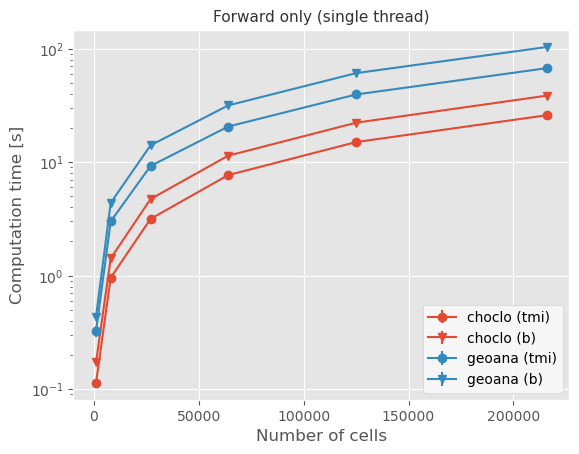

In [25]:
forward_only = True
title = get_title(forward_only, parallel=False)

colors = ["C0", "C1", "C2", "C3"]
markers = ["o", "v"]

for color, engine in zip(colors, vector_serial.engine.values):
    for marker, field in zip(markers, vector_serial.field.values):
        tmp = vector_serial.sel(engine=engine, field=field, forward_only=forward_only)
        plt.errorbar(tmp.n_cells, tmp.times, yerr=tmp.times_std, label=f"{engine} ({field})", marker=marker, color=color)
    
plt.yscale("log")
plt.xlabel("Number of cells")
plt.ylabel("Computation time [s]")
plt.title(title)
plt.legend()
plt.show()

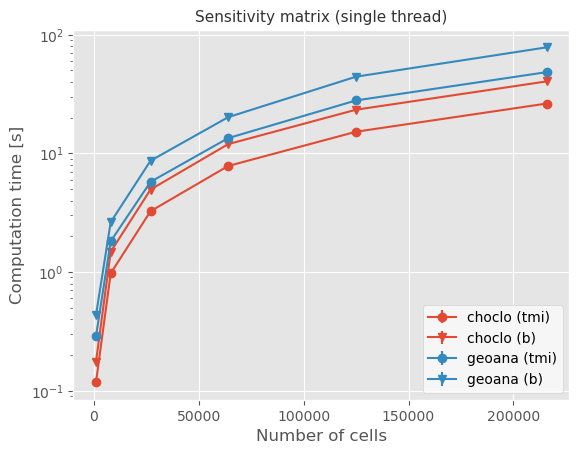

In [26]:
forward_only = False
title = get_title(forward_only, parallel=False)

colors = ["C0", "C1", "C2", "C3"]
markers = ["o", "v"]

for color, engine in zip(colors, vector_serial.engine.values):
    for marker, field in zip(markers, vector_serial.field.values):
        tmp = vector_serial.sel(engine=engine, field=field, forward_only=forward_only)
        plt.errorbar(tmp.n_cells, tmp.times, yerr=tmp.times_std, label=f"{engine} ({field})", marker=marker, color=color)
    
plt.yscale("log")
plt.xlabel("Number of cells")
plt.ylabel("Computation time [s]")
plt.title(title)
plt.legend()
plt.show()

In [27]:
ratii = (
    vector_serial.times.sel(forward_only=True, engine="geoana") 
    / vector_serial.times.sel(forward_only=True, engine="choclo")
)
ratii.name = "Ratio (geoana/choclo)"
ratii

<xarray.DataArray 'Ratio (geoana/choclo)' (n_cells: 6, field: 2)> Size: 96B
array([[2.84552383, 2.51160341],
       [3.13402094, 3.08822013],
       [2.92421481, 2.97346018],
       [2.67606028, 2.77049615],
       [2.62506793, 2.73420763],
       [2.59734811, 2.68086565]])
Coordinates:
  * n_cells       (n_cells) int32 24B 1000 8000 27000 64000 125000 216000
  * field         (field) object 16B 'tmi' 'b'
    forward_only  bool 1B True

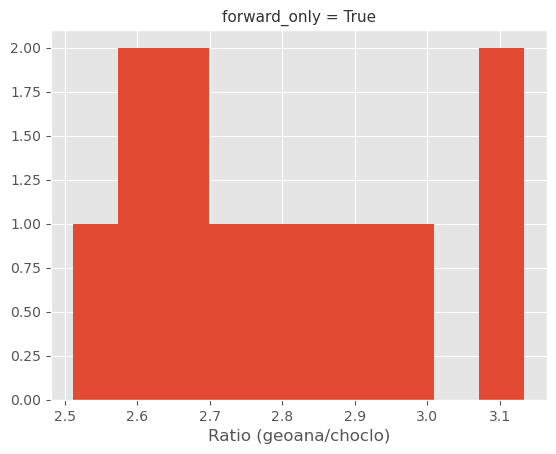

In [28]:
ratii.plot.hist()
plt.show()

In [29]:
ratii.values.min(), ratii.values.max()

(2.511603413241612, 3.1340209357786106)

## Vector model (in parallel)

The benchmarks that store the matrix in ram were killed (too much memory consumption from geoana).

In [30]:
fname = results_dir / "benchmarks-parallel-vector.nc"
vector_parallel = xr.load_dataset(fname)
vector_parallel

<xarray.Dataset> Size: 694B
Dimensions:       (n_cells: 5, engine: 2, forward_only: 2, field: 2)
Coordinates:
  * n_cells       (n_cells) int32 20B 8000 64000 216000 512000 1000000
  * engine        (engine) object 16B 'choclo' 'geoana'
  * field         (field) object 16B 'tmi' 'b'
  * forward_only  (forward_only) bool 2B True False
Data variables:
    times         (forward_only, n_cells, field, engine) float64 320B 0.1652 ...
    times_std     (forward_only, n_cells, field, engine) float64 320B 0.00462...
Attributes:
    n_receivers:  3600

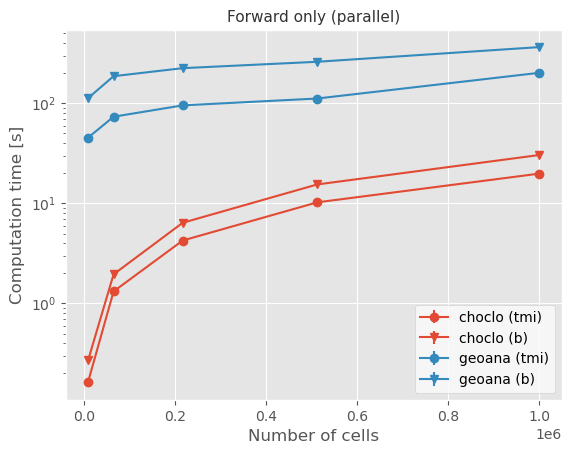

In [31]:
forward_only = True
title = get_title(forward_only, parallel=True)

colors = ["C0", "C1", "C2", "C3"]
markers = ["o", "v"]

for color, engine in zip(colors, vector_parallel.engine.values):
    for marker, field in zip(markers, vector_parallel.field.values):
        tmp = vector_parallel.sel(engine=engine, field=field, forward_only=forward_only)
        plt.errorbar(tmp.n_cells, tmp.times, yerr=tmp.times_std, label=f"{engine} ({field})", marker=marker, color=color)
    
plt.yscale("log")
plt.xlabel("Number of cells")
plt.ylabel("Computation time [s]")
plt.title(title)
plt.legend()
plt.show()

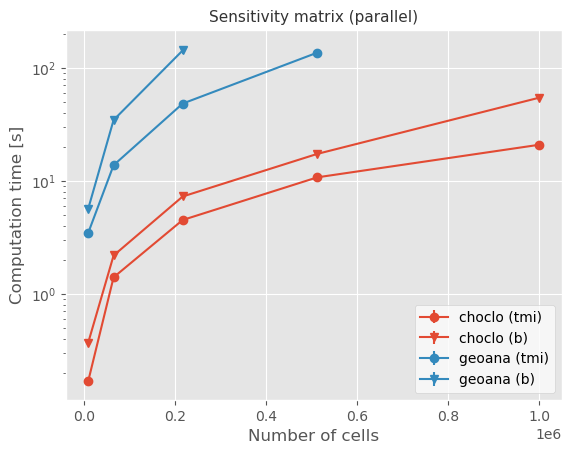

In [32]:
forward_only = False
title = get_title(forward_only, parallel=True)

colors = ["C0", "C1", "C2", "C3"]
markers = ["o", "v"]

for color, engine in zip(colors, vector_parallel.engine.values):
    for marker, field in zip(markers, vector_parallel.field.values):
        tmp = vector_parallel.sel(engine=engine, field=field, forward_only=forward_only)
        plt.errorbar(tmp.n_cells, tmp.times, yerr=tmp.times_std, label=f"{engine} ({field})", marker=marker, color=color)
    
plt.yscale("log")
plt.xlabel("Number of cells")
plt.ylabel("Computation time [s]")
plt.title(title)
plt.legend()
plt.show()

In [33]:
ratii = (
    vector_parallel.times.sel(forward_only=True, engine="geoana") 
    / vector_parallel.times.sel(forward_only=True, engine="choclo")
)
ratii.name = "Ratio (geoana/choclo)"
ratii

<xarray.DataArray 'Ratio (geoana/choclo)' (n_cells: 5, field: 2)> Size: 80B
array([[275.11454673, 416.61849325],
       [ 55.7511455 ,  95.55952616],
       [ 22.42913414,  35.11664477],
       [ 10.90904321,  16.83328209],
       [ 10.179309  ,  11.98647672]])
Coordinates:
  * n_cells       (n_cells) int32 20B 8000 64000 216000 512000 1000000
  * field         (field) object 16B 'tmi' 'b'
    forward_only  bool 1B True

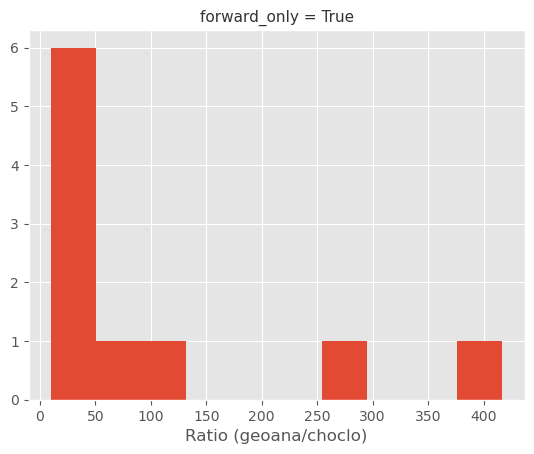

In [34]:
ratii.plot.hist()
plt.show()

In [35]:
ratii.values.min(), ratii.values.max()

(10.179309004623441, 416.61849325034257)